# Study of the optimized input geometries

The optimized geometry is found for each molecule before running the calculations of the desired quantities studied here. These geometry optimizations are performed for each set of input parameters, that is, for each combination of grid step `hgrids` and grid extension `rmult`.

The quantities of interest (phonon energies, Raman and infrared intensities, mean vibrational and electronic polarizabilities) depend on the initial geometry. The latter must correspond to the ground state, where no forces apply on the atoms of the system in theory. In practice, we look for the minimal forces via updates of the geometry given the forces of a previous calculation, until a convergence is reached. It might prove interesting to look at the evolution of these optimized geometries as the precision of the calculation is increased, either by increasing the grid extension or decreasing the grid step.

In [1]:
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
from mybigdft import Posinp

conn = sqlite3.connect("../results.db")
c = conn.cursor()

In [2]:
# Set parameters for matplotlib
plt.rcParams.update({'font.size': 14})
colors = ['#d73027', '#f46d43', '#aaaaaa', '#66bd63', '#1a9850']

## Define some global variables

These variables store all the relevant data to be used in the following.

In [3]:
# Read some values from the database
HGRIDS = [hg for (hg,) in c.execute("SELECT * FROM hgrid ORDER BY value DESC").fetchall()]
RMULTS = [val for val in c.execute("SELECT * FROM rmult").fetchall()]
MOLECULES = [name for (name,) in c.execute("SELECT name FROM molecule").fetchall()]
NOTEBOOKS = c.execute("SELECT id, molecule, hgrid, frmult, crmult FROM notebook").fetchall()

In [4]:
# Be sure to run the post_processing.ipynb notebook to make sure the
# converged_param table is in the database.
data = c.execute("""SELECT * FROM converged_param""").fetchall()
CONVERGED_PARAMS = {
    name: {"hgrids": hg, "rmult": [frm, crm]}
    for (name, hg, frm, crm) in data
}
# Looking at the convergence data, one suspects that the correct
# values for hgrids should be 0.38 for the CH4 molecule
CONVERGED_PARAMS["CH4"]["hgrids"] = 0.38

In [5]:
# Read the optimized geometry found for each notebook
POSINPS = {}
for (id_nb, molecule, hg, frm, crm) in NOTEBOOKS:
    try:
        posinp = Posinp.from_file(
            f"../rm_{int(frm)}_{int(crm)}/hg_{hg:.2f}/{molecule}/geopt/final_{molecule}.xyz"
        )
        # We also add some metadata to the posinp
        posinp.id = id_nb
        posinp.molecule = molecule
        posinp.hgrids = hg
        posinp.rmult = [frm, crm]
        posinp.converged = (
            [frm, crm] >= CONVERGED_PARAMS[molecule]["rmult"]
            and hg <= CONVERGED_PARAMS[molecule]["hgrids"]
        )
        # The posinps for each molecule are stored in a list
        try:
            POSINPS[molecule].append(posinp)
        except KeyError:
            POSINPS[molecule] = [posinp]
    except FileNotFoundError:
        pass

In [6]:
assert len(POSINPS) == 11

In [7]:
def plot_distances(name, atoms_id, ylabel, only_converged=False):
    """
    Function plotting the variation, upon modification of some BigDFT
    input parameters (namely, the grid step and the grid extension),
    of some distances within a molecule.
    
    Parameters
    ----------
    name : str
        Name of the molecule.
    atoms_id : list of tuples of length 2
        List used to find the distance between two atoms, identified
        by their position in the posinp
    ylabel : str
        Label of the y-axis.
    only_converged : bool
        If `True`, then only the results coming from a converged posinp
        are plotted ("converged" in the sense that the input parameters
        used to get these optimized positions were such that the
        precision per atom on the total energy of the system is below
        the desired value of 1 meV).
    """
    # Gather all the relevant posinps
    if only_converged:
        posinps = [
            posinp for posinp in POSINPS[name] if posinp.converged
        ]
    else:
        posinps = POSINPS[name]
    # Gather all the relevant distances and group them by rmult used
    data = [[] for _ in range(len(RMULTS))]  # y-axis values (distances)
    ids = [[] for _ in range(len(RMULTS))]  # x-axis (IDs)
    for posinp in posinps:
        # Do not take into account large hgrids when F atom in name:
        # the BigDFT results are bad in that case (as stated in the
        # BigDFT outputs).
        if not ("F" in name and posinp.hgrids > 0.35):
            x = (posinp.id - 1) // len(MOLECULES)  # x value
            i =  x % len(RMULTS)  # ID of the given rmult
            distances = [
                posinp.distance(*atoms)
                for atoms in atoms_id
            ]  # y-values
            data[i] += distances
            ids[i] += [x]*len(distances)
    # Plot the distances for each rmult
    for i, (x, values) in enumerate(zip(ids, data)):
        frm, crm = RMULTS[i]
        label = f"Grid extension = [{frm}, {crm}]"
        plt.scatter(x, values, c=colors[i], label=label)
    # Plot vertical lines to distinguish the various hgrids
    locs = [
        x * len(RMULTS) + len(RMULTS) - 0.5
        for x in range(len(HGRIDS)-1)
    ]
    ylim = plt.ylim()
    plt.vlines(locs, *ylim, linewidth=1)
    # Set xticks telling the the hgrid values
    locs = [
        x * len(RMULTS) + len(RMULTS) / 2 -0.5
        for x in range(len(HGRIDS))
    ]
    labels = [hg for hg in HGRIDS]
    plt.xticks(locs, labels)
    # Set ylim according to the plotted distances
    distances = [item for sublist in data for item in sublist]
    d_min = min(distances)
    d_max = max(distances)
    δ = (d_max - d_min) / 25
    plt.ylim(d_min-δ, d_max+δ)
    # Set xlim
    plt.xlim(-1, len(NOTEBOOKS) / len(MOLECULES))
    # Finalize plot
    plt.xlabel("Grid step")
    plt.ylabel(ylabel)
    plt.legend(loc=6, bbox_to_anchor=(1, 0.5))
    plt.title(name)
    plt.show()

In [8]:
def distances_stats(name, atoms_id, only_converged=False,
                    only_not_converged=False, verbosity=True):
    """
    Find the mean value and the standard deviation of a specific
    set of inter-atomic distances for a given molecule. You can
    specifically filter the distances coming from converged or
    not converged geometries ("converged" in the sense that the
    input parameters used to get these optimized positions were
    such that the precision per atom on the total energy of the
    system is below the desired value of 1 meV). The default is
    to mix both values.
    
    Parameters
    ----------
    name : str
        Name of the molecule.
    atoms_id : list of tuples of length 2
        List used to find the distance between two atoms, identified
        by their position in the posinp
    only_converged : bool
        If `True`, then only the results coming from converged posinps
        are used to define the stats.
    only_not_converged : bool
        If `True`, then only the results coming from non-converged
        posinps are used to define the stats.
    """
    # Gather all the relevant posinps
    if only_converged:
        posinps = [
            posinp for posinp in POSINPS[name] if posinp.converged
        ]
    elif only_not_converged:
        posinps = [
            posinp for posinp in POSINPS[name] if not posinp.converged
        ]
    else:
        posinps = POSINPS[name]
    # Gather all the relevant distances
    distances = [
        posinp.distance(*atoms)
        for atoms in atoms_id
        for posinp in posinps
        if not ("F" in name and posinp.hgrids > 0.35)
    ]
    mean = np.mean(distances)
    std_dev = np.std(distances)
    if verbosity:
        results = f"mean = {mean:1.7f} A; std. dev. = {std_dev:.2e} A; std. dev / mean = {std_dev/mean:.3e}"
        print(results)
    return mean, std_dev
    
# assert distances_stats("CO", [(1, 0)]) == "mean = 1.1252628 A; std. dev. = 2.42e-04 A"

## CO

The plots in this notebook will always look the same. The goal is to represent the variation of a particular (set of) inter-atomic distance(s) in the molecules of interest with respect to the quality of the input parameters, that is the value of the grid step and of the grid extension of BigDFT wavelet basis set.

The x-axis represents the grid step: the lower it is, the better the results are. For each grid step, various grid extensions were used, represented by the colors : from red to green, that is, from small to large grid extension, the quality of the results increase. This means that the best results correspond to a grid step of 0.16 and a grid extension of [9, 12].

We can say that a convergence was attained when the distances do not vary greatly when the quality of the calculations is increased. After such a visualization, it would be nice to look at the results that can be considered as converged up to 1 meV per atom (which is the quality we are aiming at for the phonon modes computations) and define an error bar for each distance, and sum it up. We could also compute the same type of error when the calculation is not supposed to be converged : this would help us see if our convergence criterion is correct (namely, the mean value and/or the standard deviation should change drastically).

Here, the first example is the CO molecule. As you can see, the C-O distance does not vary when the grid extension is larger or equal to [6, 9] for each grid step. Note also how a convergence is reached when the grid step is decreased. Note that the convergence of 1 meV per atom is reached for a grid extension of [6, 9] and for a grid step of 0.24. These results seem to align with our hypothesis. It should be checked quantitatively for each molecule tested here (when enough data is available).

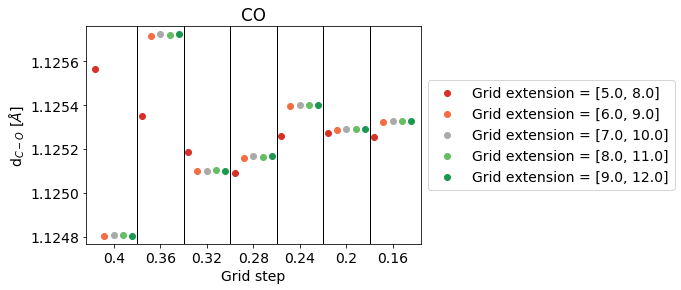

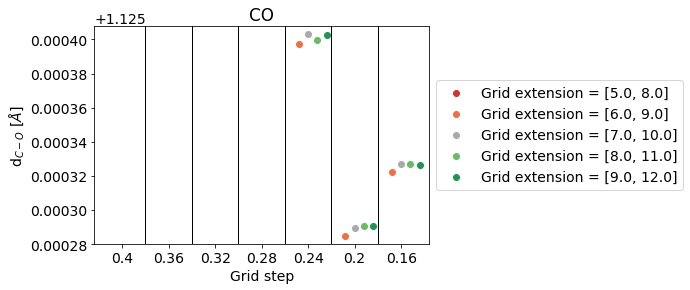

mean = 1.1253384 A; std. dev. = 4.66e-05 A; std. dev / mean = 4.139e-05
mean = 1.1252233 A; std. dev. = 2.89e-04 A; std. dev / mean = 2.568e-04


(1.1252233254827861, 0.0002890049942489193)

In [9]:
name = "CO"
ylabel = "d$_{C-O}$ [$\AA$]"
atoms_id = [(0, 1)]
plot_distances(name, atoms_id, ylabel)
plot_distances(name, atoms_id, ylabel, only_converged=True)
distances_stats(name, atoms_id, only_converged=True),
distances_stats(name, atoms_id, only_not_converged=True)

## N2

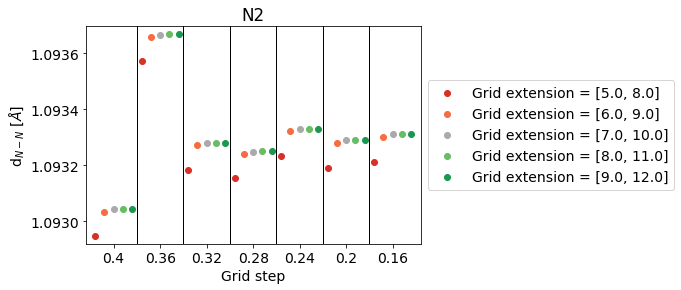

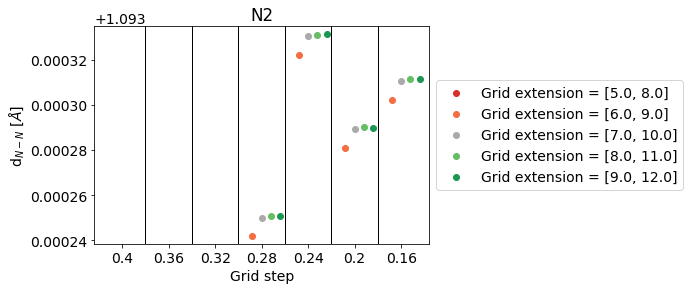

mean = 1.0932934 A; std. dev. = 3.01e-05 A; std. dev / mean = 2.750e-05
mean = 1.0932865 A; std. dev. = 2.36e-04 A; std. dev / mean = 2.156e-04


(1.0932865114703982, 0.00023572863939905615)

In [10]:
name = "N2"
ylabel = "d$_{N-N}$ [$\AA$]"
atoms_id = [(0, 1)]
plot_distances(name, atoms_id, ylabel)
plot_distances(name, atoms_id, ylabel, only_converged=True)
distances_stats(name, atoms_id, only_converged=True),
distances_stats(name, atoms_id, only_not_converged=True)

## NH$_3$

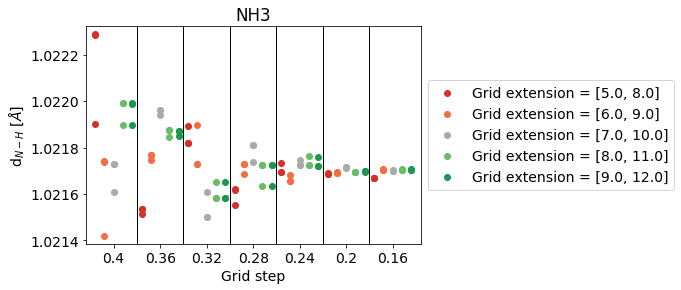

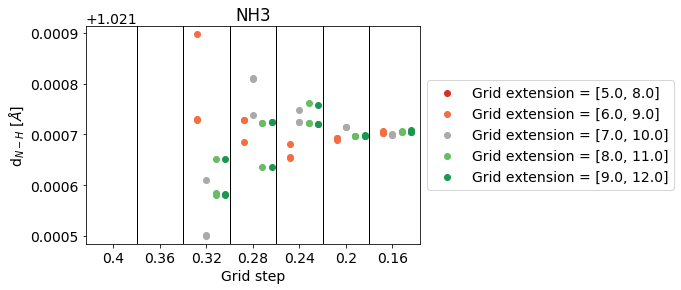

mean = 1.0216951 A; std. dev. = 6.37e-05 A; std. dev / mean = 6.238e-05
mean = 1.0217918 A; std. dev. = 1.78e-04 A; std. dev / mean = 1.739e-04


(1.021791846354245, 0.00017773367888304308)

In [11]:
name = "NH3"
ylabel = "d$_{N-H}$ [$\AA$]"
atoms_id = [(0, 1), (0, 2), (0, 3)]
plot_distances(name, atoms_id, ylabel)
plot_distances(name, atoms_id, ylabel, only_converged=True)
distances_stats(name, atoms_id, only_converged=True),
distances_stats(name, atoms_id, only_not_converged=True)

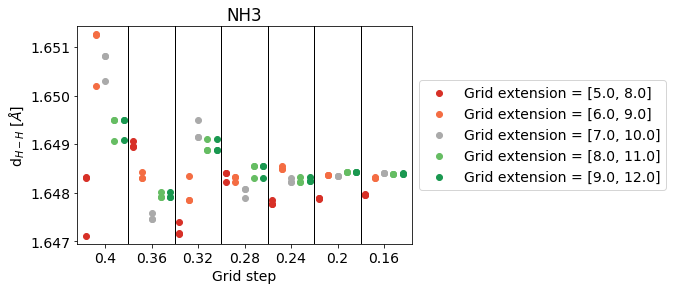

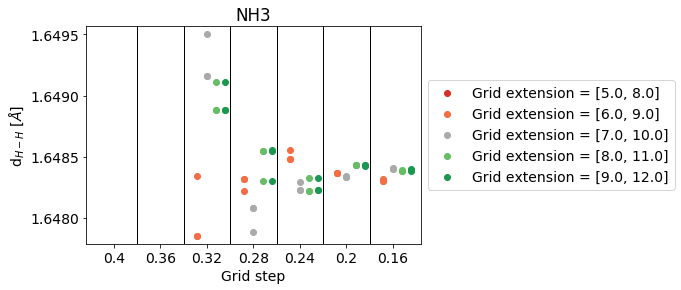

mean = 1.6484389 A; std. dev. = 3.08e-04 A; std. dev / mean = 1.870e-04
mean = 1.6485424 A; std. dev. = 1.08e-03 A; std. dev / mean = 6.569e-04


(1.648542373506571, 0.0010830063307746415)

In [12]:
name = "NH3"
ylabel = "d$_{H-H}$ [$\AA$]"
atoms_id = [(1, 2), (1, 3), (2, 3)]
plot_distances(name, atoms_id, ylabel)
plot_distances(name, atoms_id, ylabel, only_converged=True)
distances_stats(name, atoms_id, only_converged=True),
distances_stats(name, atoms_id, only_not_converged=True)

## NF$_3$

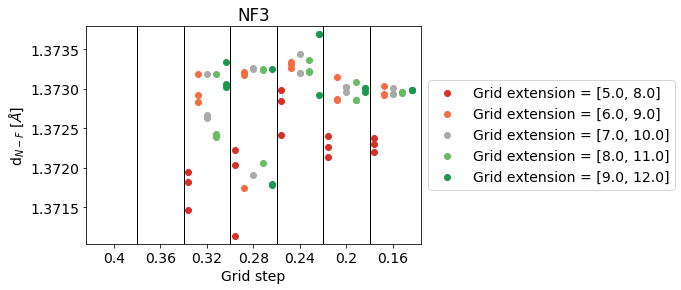

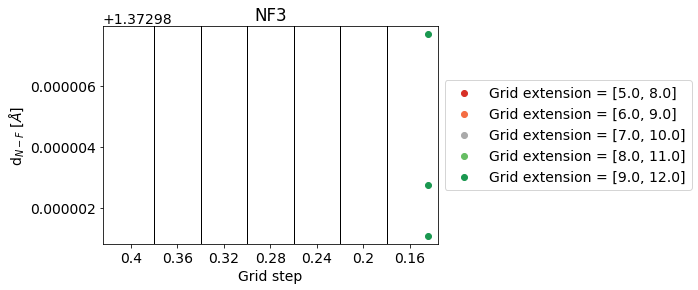

mean = 1.3729838 A; std. dev. = 2.79e-06 A; std. dev / mean = 2.031e-06
mean = 1.3727982 A; std. dev. = 5.33e-04 A; std. dev / mean = 3.886e-04


(1.3727982445653168, 0.0005334280596367963)

In [13]:
name = "NF3"
ylabel = "d$_{N-F}$ [$\AA$]"
atoms_id = [(0, 1), (0, 2), (0, 3)]
plot_distances(name, atoms_id, ylabel)
plot_distances(name, atoms_id, ylabel, only_converged=True)
distances_stats(name, atoms_id, only_converged=True),
distances_stats(name, atoms_id, only_not_converged=True)

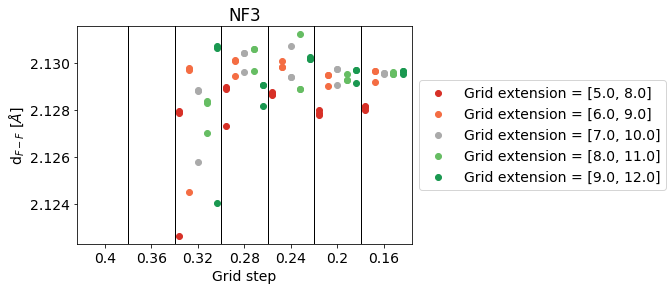

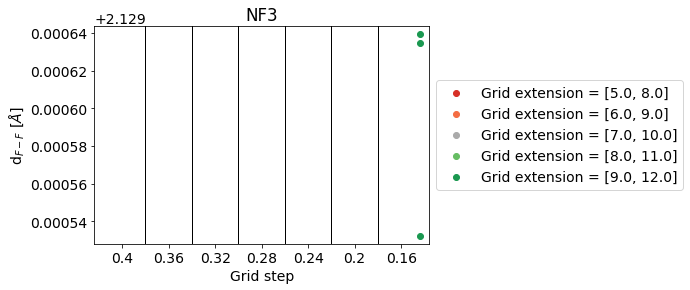

mean = 2.1296021 A; std. dev. = 4.93e-05 A; std. dev / mean = 2.313e-05
mean = 2.1290113 A; std. dev. = 1.45e-03 A; std. dev / mean = 6.822e-04


(2.1290113115888514, 0.0014523190873089499)

In [14]:
name = "NF3"
ylabel = "d$_{F-F}$ [$\AA$]"
atoms_id = [(1, 2), (1, 3), (2, 3)]
plot_distances(name, atoms_id, ylabel)
plot_distances(name, atoms_id, ylabel, only_converged=True)
distances_stats(name, atoms_id, only_converged=True),
distances_stats(name, atoms_id, only_not_converged=True)

## CH$_4$

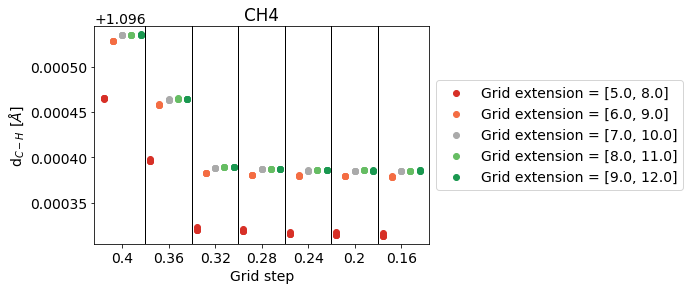

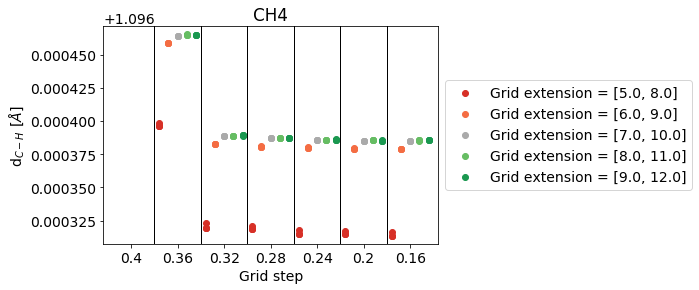

mean = 1.0963844 A; std. dev. = 3.99e-05 A; std. dev / mean = 3.641e-05
mean = 1.0965200 A; std. dev. = 2.73e-05 A; std. dev / mean = 2.491e-05


(1.0965199790680435, 2.7316611148332883e-05)

In [15]:
name = "CH4"
ylabel = "d$_{C-H}$ [$\AA$]"
atoms_id = [(0, 1), (0, 2), (0, 3), (0, 4)]
plot_distances(name, atoms_id, ylabel)
plot_distances(name, atoms_id, ylabel, only_converged=True)
distances_stats(name, atoms_id, only_converged=True),
distances_stats(name, atoms_id, only_not_converged=True)

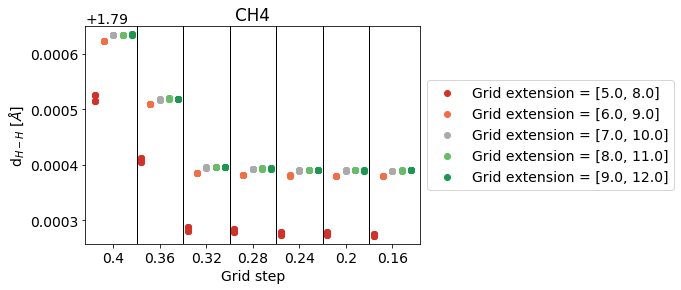

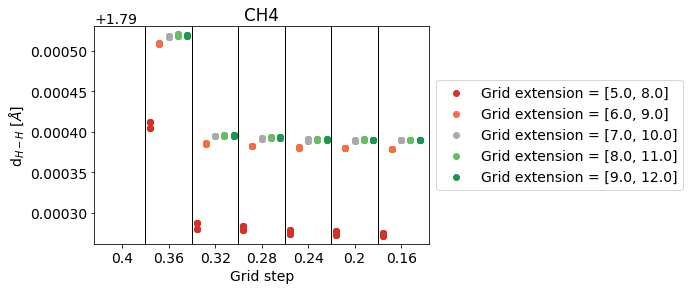

mean = 1.7903883 A; std. dev. = 6.52e-05 A; std. dev / mean = 3.642e-05
mean = 1.7906096 A; std. dev. = 4.47e-05 A; std. dev / mean = 2.495e-05


(1.7906096276460517, 4.4667840104973656e-05)

In [16]:
name = "CH4"
ylabel = "d$_{H-H}$ [$\AA$]"
atoms_id = [(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]
plot_distances(name, atoms_id, ylabel)
plot_distances(name, atoms_id, ylabel, only_converged=True)
distances_stats(name, atoms_id, only_converged=True),
distances_stats(name, atoms_id, only_not_converged=True)

## SiF$_4$

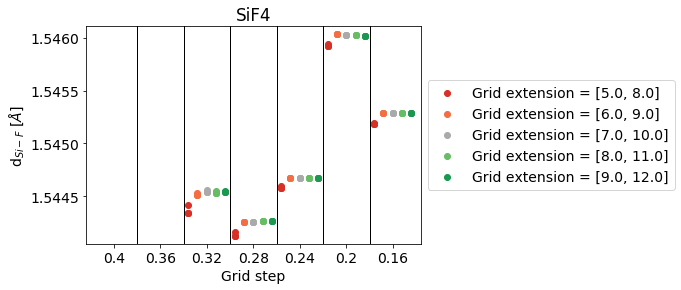

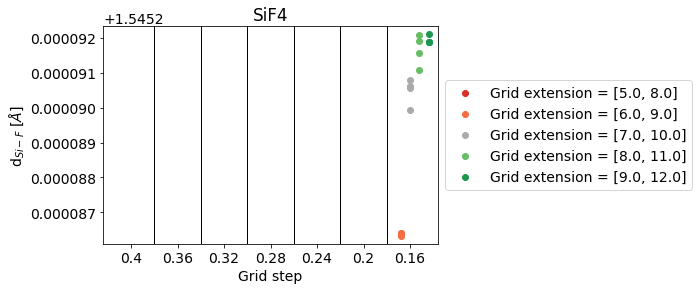

mean = 1.5452901 A; std. dev. = 2.24e-06 A; std. dev / mean = 1.450e-06
mean = 1.5448655 A; std. dev. = 6.75e-04 A; std. dev / mean = 4.368e-04


(1.544865463637949, 0.0006748369213029877)

In [17]:
name = "SiF4"
ylabel = "d$_{Si-F}$ [$\AA$]"
atoms_id = [(0, 1), (0, 2), (0, 3), (0, 4)]
plot_distances(name, atoms_id, ylabel)
plot_distances(name, atoms_id, ylabel, only_converged=True)
distances_stats(name, atoms_id, only_converged=True),
distances_stats(name, atoms_id, only_not_converged=True)

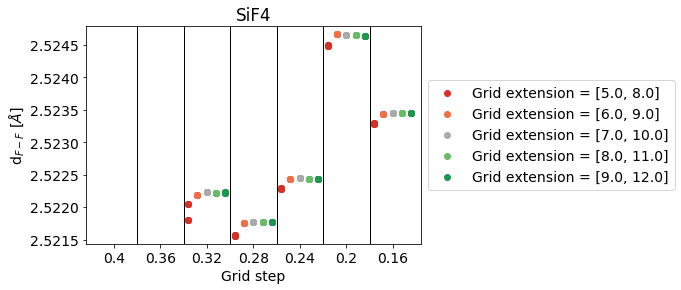

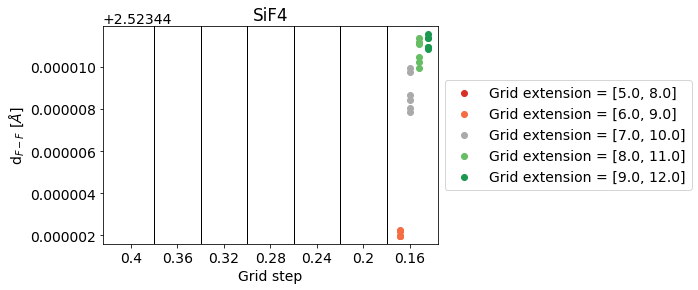

mean = 2.5234482 A; std. dev. = 3.67e-06 A; std. dev / mean = 1.454e-06
mean = 2.5227547 A; std. dev. = 1.10e-03 A; std. dev / mean = 4.369e-04


(2.5227547368112195, 0.0011022277218743829)

In [18]:
name = "SiF4"
ylabel = "d$_{F-F}$ [$\AA$]"
atoms_id = [(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]
plot_distances(name, atoms_id, ylabel)
plot_distances(name, atoms_id, ylabel, only_converged=True)
distances_stats(name, atoms_id, only_converged=True),
distances_stats(name, atoms_id, only_not_converged=True)

## HCCH

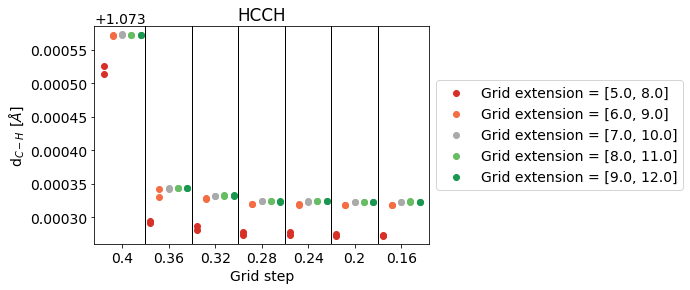

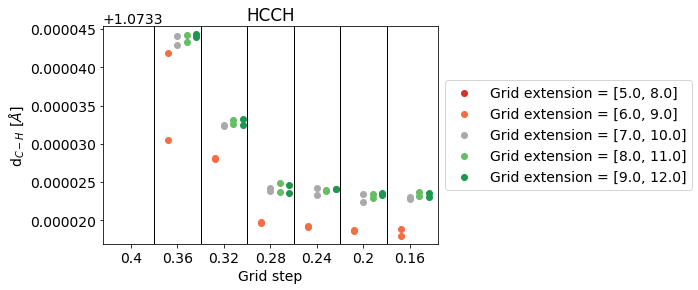

mean = 1.0733272 A; std. dev. = 7.80e-06 A; std. dev / mean = 7.267e-06
mean = 1.0734078 A; std. dev. = 1.42e-04 A; std. dev / mean = 1.320e-04


(1.0734078276114443, 0.00014165640062044352)

In [19]:
name = "HCCH"
ylabel = "d$_{C-H}$ [$\AA$]"
atoms_id = [(0, 1), (2, 3)]
plot_distances(name, atoms_id, ylabel)
plot_distances(name, atoms_id, ylabel, only_converged=True)
distances_stats(name, atoms_id, only_converged=True),
distances_stats(name, atoms_id, only_not_converged=True)

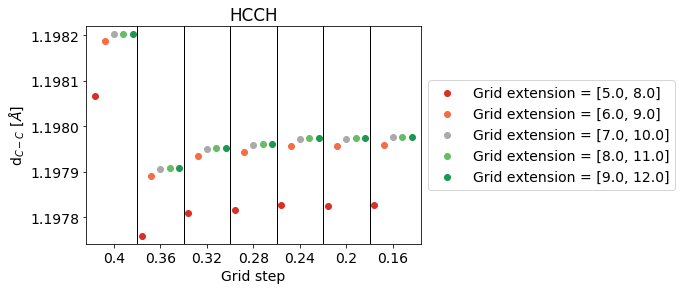

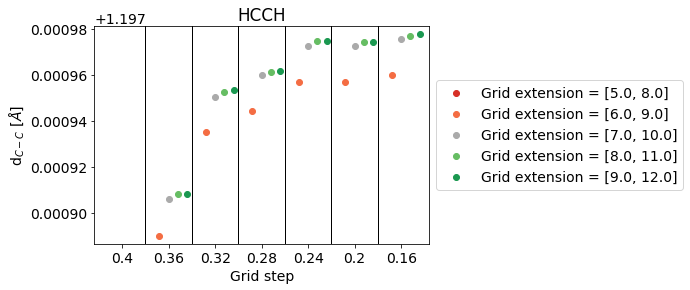

mean = 1.1979533 A; std. dev. = 2.51e-05 A; std. dev / mean = 2.097e-05
mean = 1.1979751 A; std. dev. = 1.84e-04 A; std. dev / mean = 1.536e-04


(1.197975055545612, 0.0001840429128812373)

In [20]:
name = "HCCH"
ylabel = "d$_{C-C}$ [$\AA$]"
atoms_id = [(1, 2)]
plot_distances(name, atoms_id, ylabel)
plot_distances(name, atoms_id, ylabel, only_converged=True)
distances_stats(name, atoms_id, only_converged=True),
distances_stats(name, atoms_id, only_not_converged=True)

## HCN

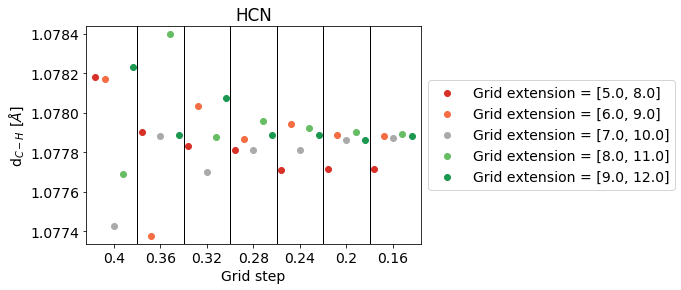

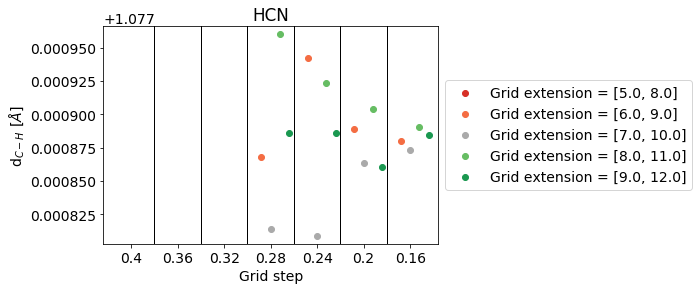

mean = 1.0778834 A; std. dev. = 3.80e-05 A; std. dev / mean = 3.526e-05
mean = 1.0778752 A; std. dev. = 2.56e-04 A; std. dev / mean = 2.374e-04


(1.0778751703144185, 0.000255913438330044)

In [21]:
name = "HCN"
ylabel = "d$_{C-H}$ [$\AA$]"
atoms_id = [(0, 1)]
plot_distances(name, atoms_id, ylabel)
plot_distances(name, atoms_id, ylabel, only_converged=True)
distances_stats(name, atoms_id, only_converged=True),
distances_stats(name, atoms_id, only_not_converged=True)

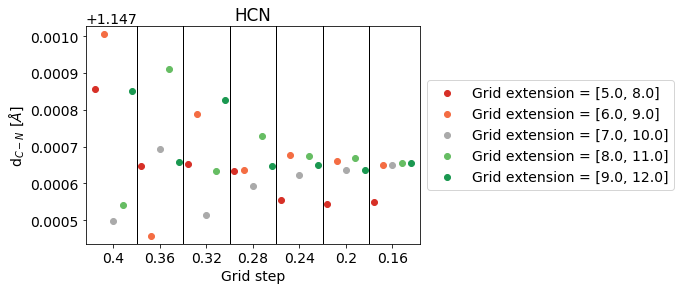

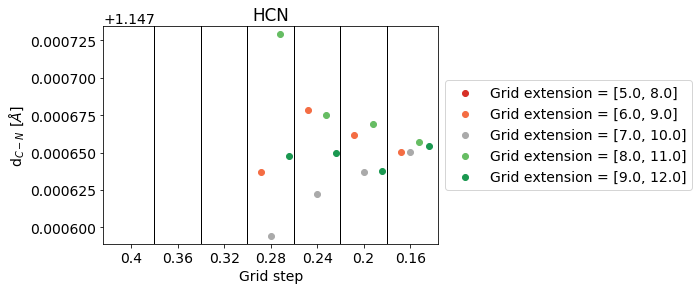

mean = 1.1476532 A; std. dev. = 2.79e-05 A; std. dev / mean = 2.435e-05
mean = 1.1476748 A; std. dev. = 1.52e-04 A; std. dev / mean = 1.323e-04


(1.147674789731931, 0.0001518213508190692)

In [22]:
name = "HCN"
ylabel = "d$_{C-N}$ [$\AA$]"
atoms_id = [(1, 2)]
plot_distances(name, atoms_id, ylabel)
plot_distances(name, atoms_id, ylabel, only_converged=True)
distances_stats(name, atoms_id, only_converged=True),
distances_stats(name, atoms_id, only_not_converged=True)

## H2O

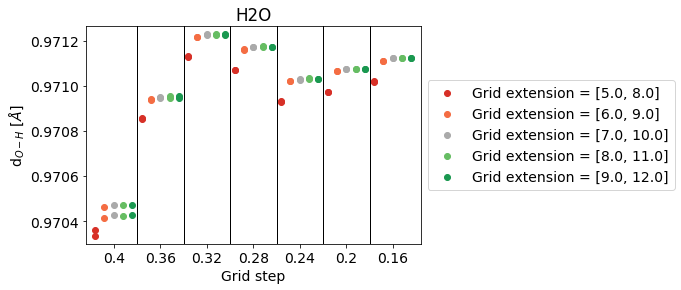

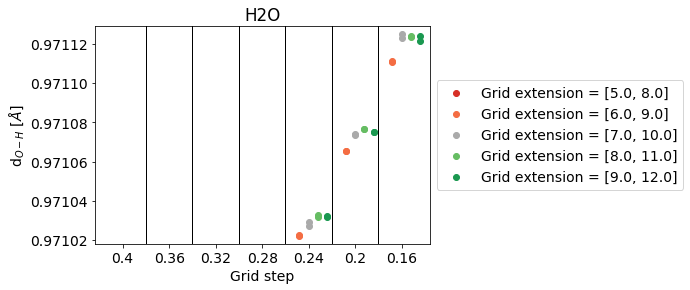

mean = 0.9710739 A; std. dev. = 3.76e-05 A; std. dev / mean = 3.873e-05
mean = 0.9709337 A; std. dev. = 2.89e-04 A; std. dev / mean = 2.980e-04


(0.9709336686136131, 0.00028935177590698805)

In [23]:
name = "H2O"
ylabel = "d$_{O-H}$ [$\AA$]"
atoms_id = [(0, 1), (0, 2)]
plot_distances(name, atoms_id, ylabel)
plot_distances(name, atoms_id, ylabel, only_converged=True)
distances_stats(name, atoms_id, only_converged=True),
distances_stats(name, atoms_id, only_not_converged=True)

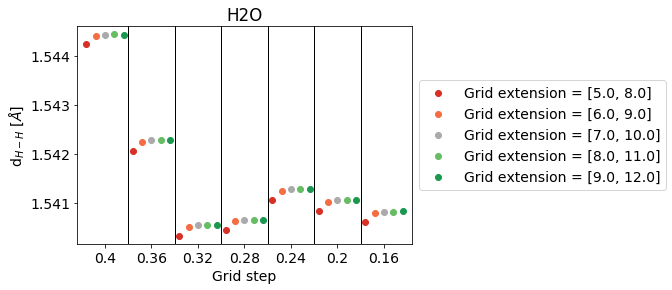

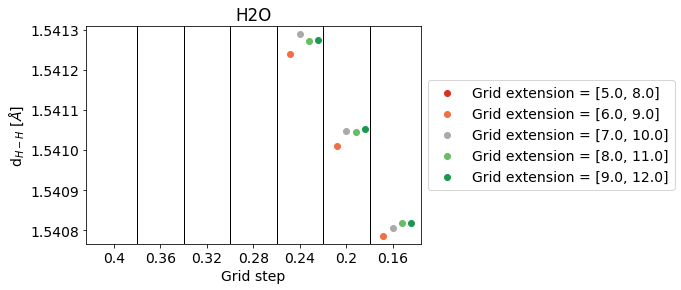

mean = 1.5410386 A; std. dev. = 1.89e-04 A; std. dev / mean = 1.228e-04
mean = 1.5417846 A; std. dev. = 1.52e-03 A; std. dev / mean = 9.866e-04


(1.5417845537594923, 0.0015211418805393564)

In [24]:
name = "H2O"
ylabel = "d$_{H-H}$ [$\AA$]"
atoms_id = [(1, 2)]
plot_distances(name, atoms_id, ylabel)
plot_distances(name, atoms_id, ylabel, only_converged=True)
distances_stats(name, atoms_id, only_converged=True),
distances_stats(name, atoms_id, only_not_converged=True)

## H3CCN

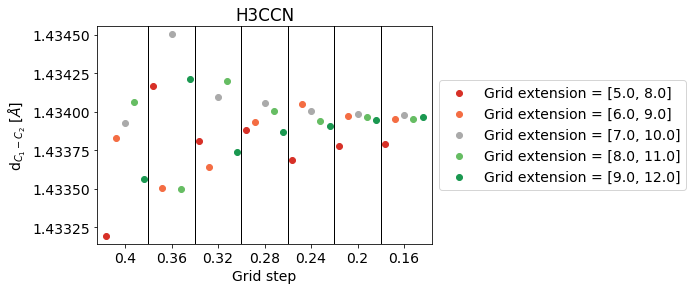

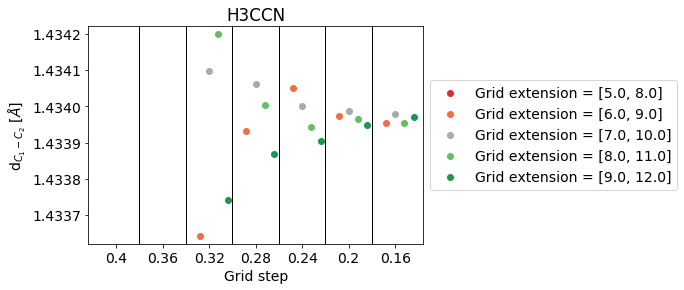

mean = 1.4339587 A; std. dev. = 1.14e-04 A; std. dev / mean = 7.960e-05
mean = 1.4338278 A; std. dev. = 3.16e-04 A; std. dev / mean = 2.202e-04


(1.4338277676480822, 0.0003157851082815638)

In [25]:
name = "H3CCN"
ylabel = "d$_{C_1-C_2}$ [$\AA$]"
atoms_id = [(0, 1)]
plot_distances(name, atoms_id, ylabel)
plot_distances(name, atoms_id, ylabel, only_converged=True)
distances_stats(name, atoms_id, only_converged=True),
distances_stats(name, atoms_id, only_not_converged=True)

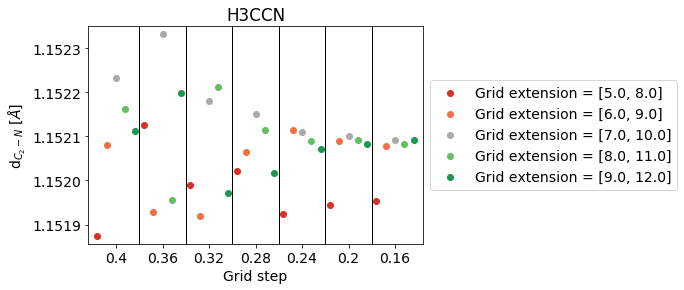

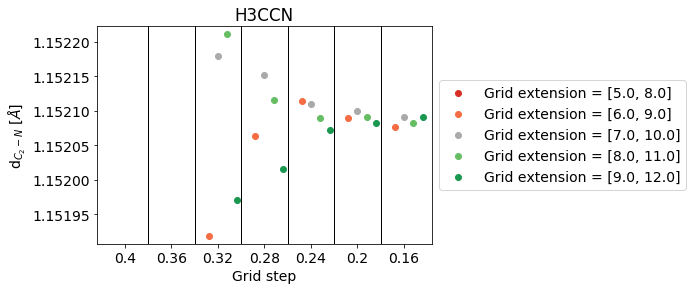

mean = 1.1520860 A; std. dev. = 6.25e-05 A; std. dev / mean = 5.426e-05
mean = 1.1520558 A; std. dev. = 1.30e-04 A; std. dev / mean = 1.126e-04


(1.1520558387657038, 0.00012975944953670367)

In [26]:
name = "H3CCN"
ylabel = "d$_{C_2-N}$ [$\AA$]"
atoms_id = [(1, 2)]
plot_distances(name, atoms_id, ylabel)
plot_distances(name, atoms_id, ylabel, only_converged=True)
distances_stats(name, atoms_id, only_converged=True),
distances_stats(name, atoms_id, only_not_converged=True)

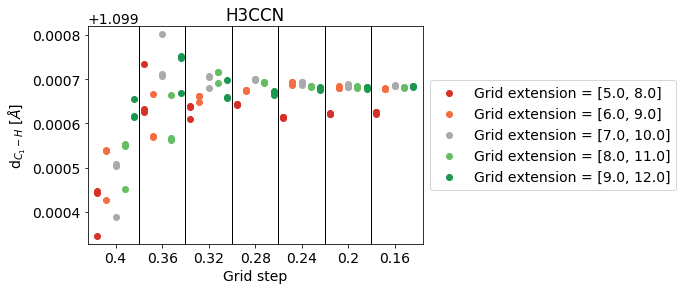

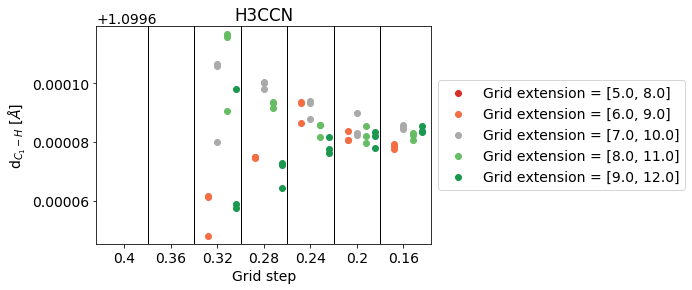

mean = 1.0996838 A; std. dev. = 1.27e-05 A; std. dev / mean = 1.154e-05
mean = 1.0995992 A; std. dev. = 9.47e-05 A; std. dev / mean = 8.615e-05


(1.0995991728048184, 9.473332625187635e-05)

In [27]:
name = "H3CCN"
ylabel = "d$_{C_1-H}$ [$\AA$]"
atoms_id = [(0, 3), (0, 4), (0, 5)]
plot_distances(name, atoms_id, ylabel)
plot_distances(name, atoms_id, ylabel, only_converged=True)
distances_stats(name, atoms_id, only_converged=True),
distances_stats(name, atoms_id, only_not_converged=True)

## H3CNC

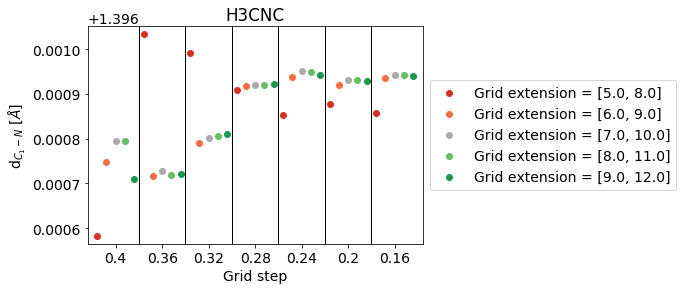

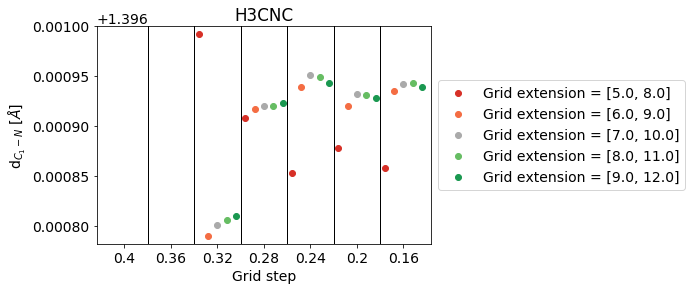

mean = 1.3969052 A; std. dev. = 5.31e-05 A; std. dev / mean = 3.799e-05
mean = 1.3967546 A; std. dev. = 1.08e-04 A; std. dev / mean = 7.749e-05


(1.3967546378024775, 0.00010823893681318486)

In [28]:
name = "H3CNC"
ylabel = "d$_{C_1-N}$ [$\AA$]"
atoms_id = [(0, 1)]
plot_distances(name, atoms_id, ylabel)
plot_distances(name, atoms_id, ylabel, only_converged=True)
distances_stats(name, atoms_id, only_converged=True),
distances_stats(name, atoms_id, only_not_converged=True)

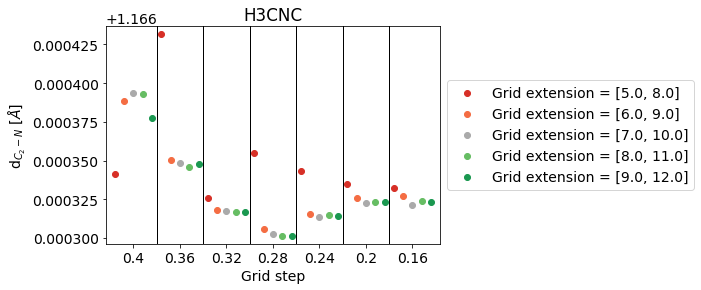

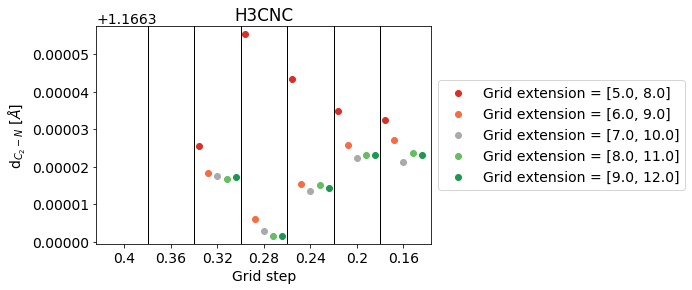

mean = 1.1663208 A; std. dev. = 1.21e-05 A; std. dev / mean = 1.034e-05
mean = 1.1663719 A; std. dev. = 2.82e-05 A; std. dev / mean = 2.420e-05


(1.166371870336602, 2.8222892681096135e-05)

In [29]:
name = "H3CNC"
ylabel = "d$_{C_2-N}$ [$\AA$]"
atoms_id = [(0, 2)]
plot_distances(name, atoms_id, ylabel)
plot_distances(name, atoms_id, ylabel, only_converged=True)
distances_stats(name, atoms_id, only_converged=True),
distances_stats(name, atoms_id, only_not_converged=True)

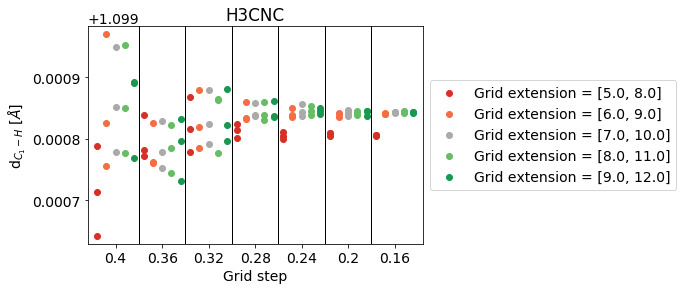

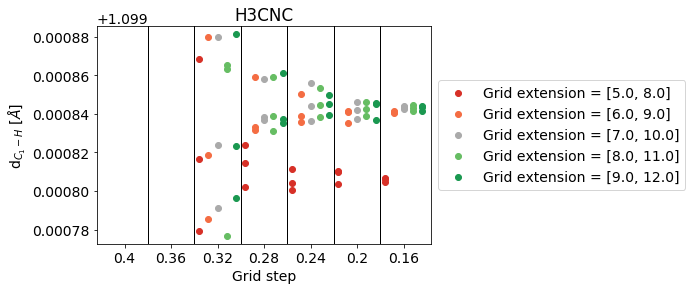

mean = 1.0998348 A; std. dev. = 2.21e-05 A; std. dev / mean = 2.009e-05
mean = 1.0998073 A; std. dev. = 7.09e-05 A; std. dev / mean = 6.446e-05


(1.0998073255276724, 7.089593710297571e-05)

In [30]:
name = "H3CNC"
ylabel = "d$_{C_1-H}$ [$\AA$]"
atoms_id = [(1, 3), (1, 4), (1, 5)]
plot_distances(name, atoms_id, ylabel)
plot_distances(name, atoms_id, ylabel, only_converged=True)
distances_stats(name, atoms_id, only_converged=True),
distances_stats(name, atoms_id, only_not_converged=True)

## Precision on the distances

The above cells show that statistics such as the mean value and the standard deviation of (almost) each distance can be conveniently accessed. Most importantly, one can easily discriminate converged and non-converged distances. Let us see how all these values can be used to assess the expected precision on the distances.

In order to do that, we need to gather the mean distances and the standard deviation for each distance. This is done in the following cells, discriminating the data coming from converged and not converged calculations.

In [31]:
# Here are gathered all the values allowing to compute the mean
# value and the standard deviations with the distances_stats function
atoms_ids = {
    "CH4": {
        "d$_{C-H}$": [(0, 1), (0, 2), (0, 3), (0, 4)],
        "d$_{H-H}$": [(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)],
    },
    "SiF4": {
        "d$_{Si-F}$": [(0, 1), (0, 2), (0, 3), (0, 4)],
        "d$_{F-F}$": [(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)],
    },
    "H2O": {"d$_{O-H}$": [(0, 1), (0, 2)], "d$_{H-H}$": [(1, 2)]},
    "HCCH": {"d$_{C-H}$": [(0, 1), (2, 3)], "d$_{C-C}$": [(1, 2)]},
    "HCN": {"d$_{C-N}$": [(1, 2)], "d$_{C-H}$": [(0, 1)]},
    "NH3": {"d$_{N-H}$": [(0, 1), (0, 2), (0, 3)], "d$_{H-H}$": [(1, 2), (1, 3), (2, 3)]},
    "NF3": {"d$_{N-F}$": [(0, 1), (0, 2), (0, 3)], "d$_{F-F}$": [(1, 2), (1, 3), (2, 3)]},
    "H3CCN": {"d$_{C_1-C_2}$": [(0, 1)], "d$_{C_2-N}$": [((1, 2))], "d$_{C_1-H}$": [(0, 3), (0, 4), (0, 5)]},
    "H3CNC": {"d$_{C_1-N}$": [(0, 1)], "d$_{C_2-N}$": [(0, 2)], "d$_{C_1-H}$": [(1, 3), (1, 4), (1, 5)]},
    "CO": {"d$_{C-O}$": [(0, 1)]},
    "N2": {"d$_{N-N}$": [(0, 1)]},
}

In [32]:
# The stats obtained along with the above plots are stored in the
# following dictionary, which has the molcule names as key. Stats for
# both converged and non-converged stats are computed, except for some
# cases defined above (where the non-converged results cannot be computed).
stats = {}
# Loop over the molecules
for name, distances in atoms_ids.items():
    stats[name] = {}
    # Loop over the distances
    for distance, atoms_id in distances.items():
        base = {"converged": None, "not_converged": None}
        stats[name][distance] = base
        # Find the converged mean distance and standard deviation
        mean_c, std_dev_c = distances_stats(
            name, atoms_id, only_converged=True, verbosity=False,
        )
        data = {"mean": mean_c, "std_dev": std_dev_c}
        stats[name][distance]["converged"] = data
        # Find the non-converged mean distance and standard deviation
        mean_nc, std_dev_nc = distances_stats(
            name, atoms_id, only_not_converged=True, verbosity=False,
        )
        data = {"mean": mean_nc, "std_dev": std_dev_nc}
        stats[name][distance]["not_converged"] = data
        # It is expected for the converged standard deviation to be larger
        # than the non-converged one; if this is not the case, print a message
        if std_dev_nc and std_dev_nc < std_dev_c:
            print(
                f"The distance {distance} of molecule {name} has a larger "
                f"standard deviation for converged calculations "
                f"({std_dev_c:.2e} > {std_dev_nc:.2e})"
            )            

The distance d$_{C-H}$ of molecule CH4 has a larger standard deviation for converged calculations (3.99e-05 > 2.73e-05)
The distance d$_{H-H}$ of molecule CH4 has a larger standard deviation for converged calculations (6.52e-05 > 4.47e-05)


As we can see here, the distances of the CH4 molecule have a larger standard deviation for converged calculations than for non-converged calculations. This is due to the fact there are too few data for non-converged calculations, the precision per atom of 1 meV on the total energy being easily attained for that molecule.

We can count the number of supposedly converged distances below a given limit in order to state which is the expected precision on the distance (within 3 sigma). This is rather similar to the study performed for the phonon energies.

In [33]:
def nb_under_3_std_dev(precision, only_converged=True,
                       only_not_converged=False):
    """
    Parameters
    ----------
    precision : float
        Precision on the distance (in A).
    
    Returns
    -------
    int
        The number of distances (supposed to be converged) in the
        test set for which three times the standard deviation is
        below the given precision.
    """
    # Set the key
    if only_converged:
        key = "converged"
    if only_not_converged:
        key = "not_converged"
    # Gather the standard deviations
    std_devs = [
        distance[key]["std_dev"]
        for distances in stats.values()
        for distance in distances.values()
    ]
    # Return the number of distances with a standard deviation
    # below the specified precision
    return sum(3*std_dev <= precision for std_dev in std_devs)

It is now possible to study how the numbers presented above evolve upon changing the precision value. This will allow us to evaluate the precision on the distances. This is done by finding the maximum difference between the converged and non-converged results for a given precision.

Precision: 1.97e-04 A
Precision: 2.12e-04 A


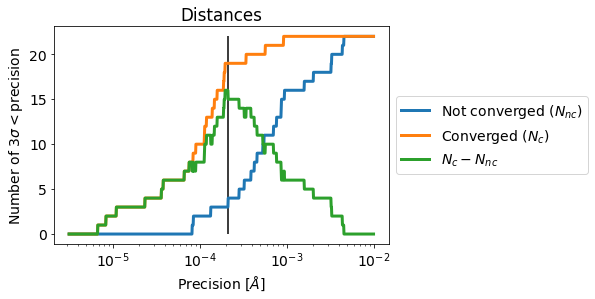

In [34]:
# Define a wide range of precisions
exponents = np.linspace(2, 5.5, 1000)
precisions = [10**(-n) for n in exponents]
# Get the number of converged and non-converged distances below that
# precision
nb_c = [nb_under_3_std_dev(precision) for precision in precisions]
nb_nc = [
    nb_under_3_std_dev(precision, only_not_converged=True)
    for precision in precisions
]
# Compute the difference between both arrays
diff = np.array(nb_c) - np.array(nb_nc)
# Find the precision, associated with the largest difference
argmax = np.argmax(diff[::-1])
precision = precisions[::-1][argmax]
print(f"Precision: {precision:.2e} A")
argmax = np.argmax(diff)
precision = precisions[argmax]
print(f"Precision: {precision:.2e} A")
# Plot all the relevant data as a function of the precision
plt.plot(precisions, nb_nc, label=r"Not converged ($N_{nc}$)", lw=3)
plt.plot(precisions, nb_c, label=r"Converged ($N_{c}$)", lw=3)
plt.plot(precisions, diff, label=r"$N_c - N_{nc}$", lw=3)
plt.xscale('log')
plt.title("Distances")
plt.xlabel(r"Precision [$\AA$]")
plt.ylabel(r"Number of $3 \sigma < $precision")
plt.vlines(precision, min(nb_nc), max(nb_c))
plt.legend(loc=6, bbox_to_anchor=(1, 0.5))
plt.show()

The results show that the difference peaks between 1.97 10$^{-4}$ and 2.12 10$^{-4}$ A. This gives an idea of the precision to be expected on the interatomic distances of neighbouring atoms when the precision per atom on the total energy is around 1 meV (~ 8 cm$^{-1}$).

## Plot the dispersion

Our main objective here is to give a broad overview on the evolution of the standard deviation between converged and not converged calculations.

This first plot has multiple goals:
- show that the standard deviation of not-converged parameters is way larger than for converged parameters
- show that three standard deviations is often below the precision found above for converged input parameters.
- show that three standard deviations is often above the precision found above for non-converged input parameters.
- show that there can be an offset of the mean values between converged and non-converged parameters.

All these can be shown by mostly comparing the converged and non-converged standard deviations of each distance. Another relevant quantity is the difference between the converged and non converged mean value of each distance. One can therefore center all the converged mean distance on 0 and show how large three standard deviations are. The non converged standard deviations can be plotted in the same manner, but centered on the difference between the converged and non-converged mean didtances. To help the viewer, vertical lines defines the +/- 2.12 10$^{-4}$ A precision limit for converged calculations.

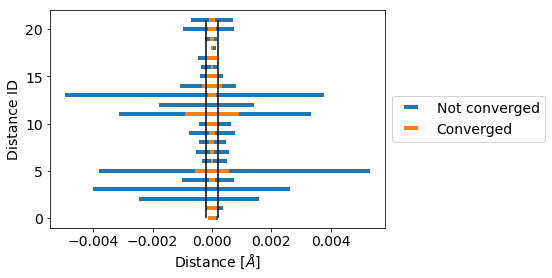

In [35]:
# Loop over the converged and not-converged data to plot the errorbars
for key in ["not_converged", "converged"]:
    x = []  # Center of each error-bar
    x_err = []  # Width of each error bar
    # Loop over the molecules
    for data in stats.values():
        # Loop over the distances
        for distance in data.values():
            # Define the width of the error-bar
            if not isinstance(distance[key]["std_dev"], np.float64):
                x_err.append(0)
            else:    
                x_err.append(3*distance[key]["std_dev"])
            # Define the center of the error-bar for non-converged results
            if key == "not_converged":
                converged_mean = distance["converged"]["mean"]
                not_converged_mean = distance["not_converged"]["mean"]
                if (not isinstance(converged_mean, np.float64) 
                        or not isinstance(not_converged_mean, np.float64)):
                    x.append(0)
                else:
                    x.append(not_converged_mean - converged_mean)
    # Set the center of the error-bars for converged results as 0
    if key == "converged":
        x = np.zeros_like(x_err)
    # Set the y-axis as an ID of the distance
    y = np.arange(len(x_err))
    # Plot the error-bars
    label = key.replace("_", " ").capitalize()
    plt.errorbar(x, y, xerr=x_err, linestyle="", elinewidth=4, label=label)
# Finalize the plot
plt.xlabel("Distance [$\AA$]")
plt.ylabel("Distance ID")
plt.vlines([-precision, precision], min(y), max(y))
plt.legend(loc=6, bbox_to_anchor=(1, 0.5))
plt.show()

Same plot as the one above, but with a shorter range on the x-axis:

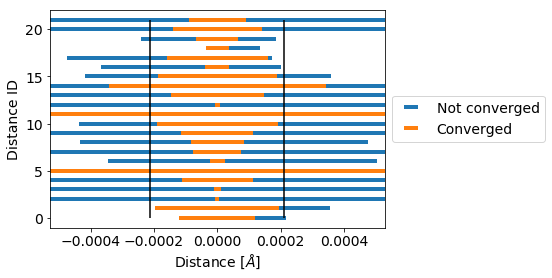

In [36]:
for key in ["not_converged", "converged"]:
    x_err = []
    x = []
    # Loop over the molecules
    for data in stats.values():
        # Loop over the distances
        for distance in data.values():
            # Define the width of the error-bar
            if not isinstance(distance[key]["std_dev"], np.float64):
                x_err.append(0)
            else:    
                x_err.append(3*distance[key]["std_dev"])
            # Define the center of the error-bar for non-converged results
            if key == "not_converged":
                converged_mean = distance["converged"]["mean"]
                not_converged_mean = distance["not_converged"]["mean"]
                if (not isinstance(converged_mean, np.float64) 
                        or not isinstance(not_converged_mean, np.float64)):
                    x.append(0)
                else:
                    x.append(not_converged_mean - converged_mean)
    if key == "converged":
        x = np.zeros_like(x_err)
    y = np.arange(len(x_err))
    label = key.replace("_", " ").capitalize()
    plt.errorbar(x, y, xerr=x_err, linestyle="", elinewidth=4, label=label)
plt.xlabel("Distance [$\AA$]")
plt.ylabel("Distance ID")
plt.vlines([-precision, precision], min(y), max(y))
plt.legend(loc=6, bbox_to_anchor=(1, 0.5))
plt.xlim(-2.5*precision, 2.5*precision)
plt.show()

A similar plot as the one above can be produced, except that the y-axis gives the mean distance for the converged calculations.

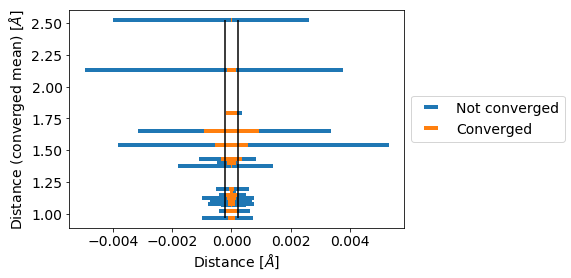

In [37]:
# Loop over the converged and not-converged data to plot the errorbars
for key in ["not_converged", "converged"]:
    x = []  # Center of each error-bar
    y = []  # Mean energy of the converged phonons
    x_err = []  # Width of each error-bars along the x-axis
    # Loop over the molecules
    for data in stats.values():
        # Loop over the phonons
        for distance in data.values():
            # Define the location on the y-axis
            converged_mean = distance["converged"]["mean"]
            y.append(converged_mean)
            # Define the width of the error-bar
            if not isinstance(distance[key]["std_dev"], np.float64):
                x_err.append(0)
            else:    
                x_err.append(3*distance[key]["std_dev"])
            # Define the center of the error-bar for non-converged results
            if key == "not_converged":
                not_converged_mean = distance["not_converged"]["mean"]
                if (not isinstance(converged_mean, np.float64) 
                        or not isinstance(not_converged_mean, np.float64)):
                    x.append(0)
                else:
                    x.append(not_converged_mean - converged_mean)
    # Set the center of the error-bars for converged results as 0
    if key == "converged":
        x = np.zeros_like(x_err)
    # Plot the error-bars
    label = key.replace("_", " ").capitalize()
    plt.errorbar(x, y, xerr=x_err, linestyle="", elinewidth=4, label=label)
# Finalize the plot
plt.xlabel("Distance [$\AA$]")
plt.ylabel("Distance (converged mean) [$\AA$]")
plt.vlines([-precision, precision], min(y), max(y))
plt.legend(loc=6, bbox_to_anchor=(1, 0.5))
plt.show()

Same plot as the one above, but with a reduced range on the x-axis:

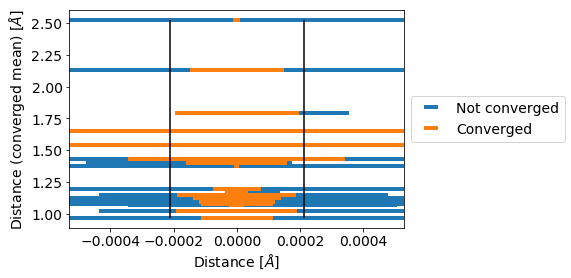

In [38]:
for key in ["not_converged", "converged"]:
    x = []  # Center of each error-bar
    y = []  # Mean value of the converged distances
    x_err = []  # Width of each error-bars along the x-axis
    # Loop over the molecules
    for data in stats.values():
        # Loop over the distances
        for distance in data.values():
            # Define the location on the y-axis
            converged_mean = distance["converged"]["mean"]
            y.append(converged_mean)
            # Define the width of the error-bar
            if not isinstance(distance[key]["std_dev"], np.float64):
                x_err.append(0)
            else:    
                x_err.append(3*distance[key]["std_dev"])
            # Define the center of the error-bar for non-converged results
            if key == "not_converged":
                not_converged_mean = distance["not_converged"]["mean"]
                if (not isinstance(converged_mean, np.float64) 
                        or not isinstance(not_converged_mean, np.float64)):
                    x.append(0)
                else:
                    x.append(not_converged_mean - converged_mean)
    # Set the center of the error-bars for converged results as 0
    if key == "converged":
        x = np.zeros_like(x_err)
    # Plot the error-bars
    label = key.replace("_", " ").capitalize()
    plt.errorbar(x, y, xerr=x_err, linestyle="", elinewidth=4, label=label)
# Finalize the plot
plt.xlabel("Distance [$\AA$]")
plt.ylabel("Distance (converged mean) [$\AA$]")
plt.vlines([-precision, precision], min(y), max(y))
plt.legend(loc=6, bbox_to_anchor=(1, 0.5))
plt.xlim(-2.5*precision, 2.5*precision)
plt.show()

Similar plots can be done for each molecule:

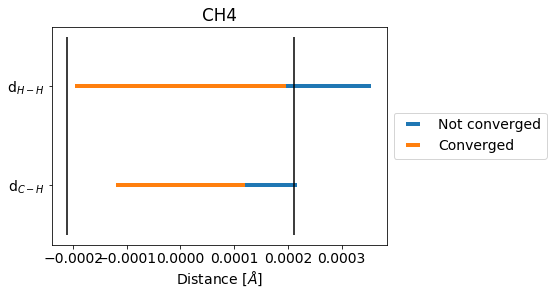

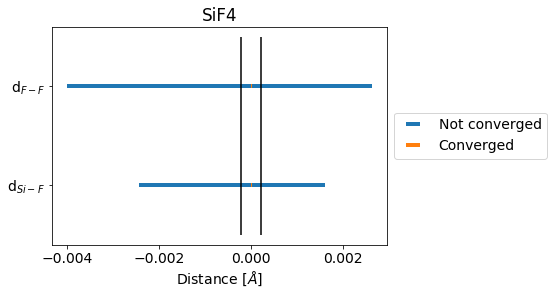

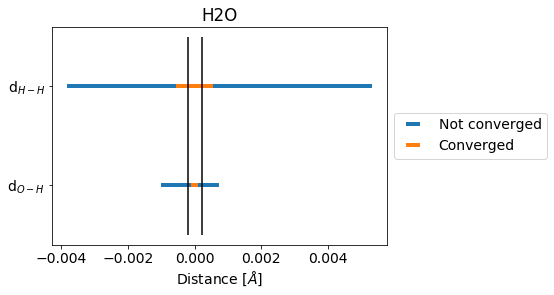

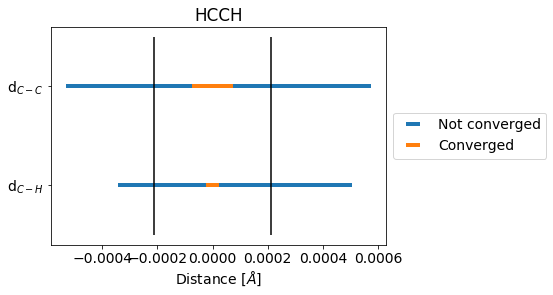

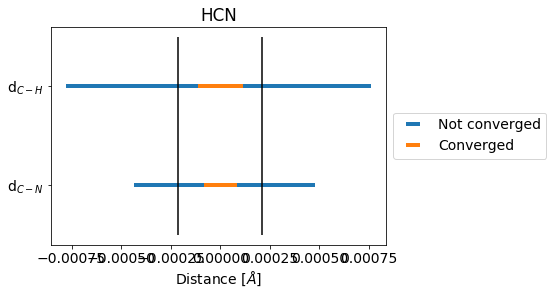

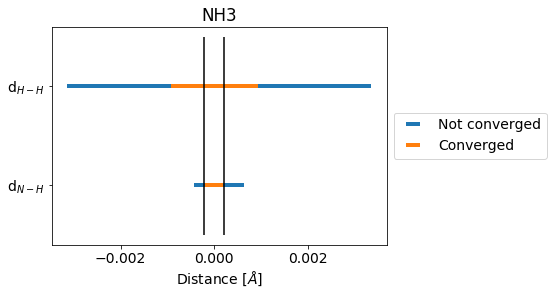

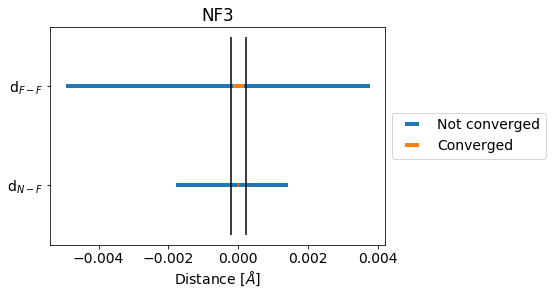

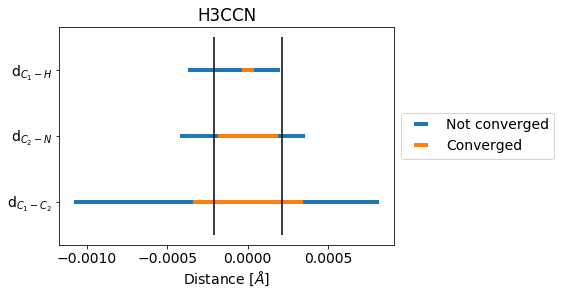

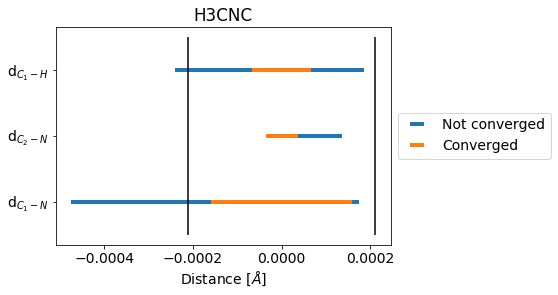

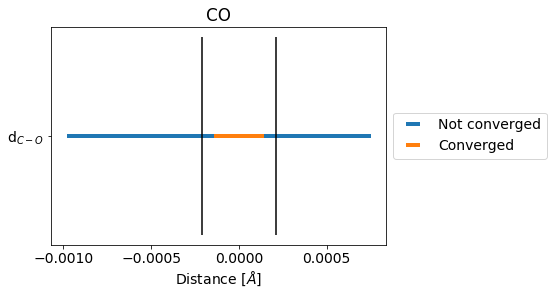

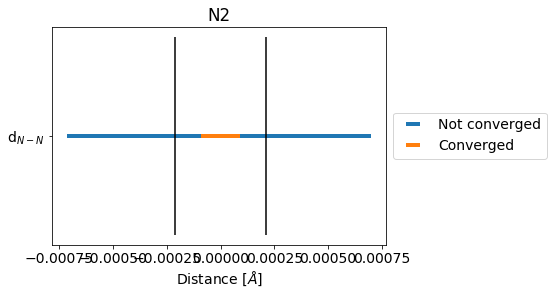

In [39]:
for molecule, data in stats.items():
    for key in ["not_converged", "converged"]:
        x_err = []
        x = []
        for value in data.values():
            if not isinstance(value[key]["std_dev"], np.float64):
                x_err.append(0)
            else:    
                x_err.append(3*value[key]["std_dev"])
            if key == "not_converged":
                converged_mean = value["converged"]["mean"]
                not_converged_mean = value["not_converged"]["mean"]
                if (not isinstance(converged_mean, np.float64) 
                        or not isinstance(not_converged_mean, np.float64)):
                    x.append(0)
                else:
                    x.append(not_converged_mean - converged_mean)
        if key == "converged":
            x = np.zeros_like(x_err)
        y = np.arange(len(x_err))
        label = key.replace("_", " ").capitalize()
        plt.errorbar(x, y, xerr=x_err, linestyle="", elinewidth=4, label=label)
    ticks = [distance for distance in data]
    plt.yticks(y, ticks)
    plt.title(molecule)
    plt.xlabel("Distance [$\AA$]")
    plt.vlines([-precision, precision], min(y)-0.5, max(y)+0.5)
    plt.legend(loc=6, bbox_to_anchor=(1, 0.5))
    plt.show()